In [1]:
from google.cloud import storage
import pandas as pd
import numpy as np
import datetime
import time
from itertools import groupby

import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

In [28]:
! pip install plotly

     |████████████████████████████████| 11.5 MB 11.0 MB/s eta 0:00:01


In [2]:
! pip install matplotlib_venn

     |████████████████████████████████| 40 kB 6.0 MB/s  eta 0:00:01
  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.5-py3-none-any.whl size=32394 sha256=ced5c7f81c9b726f45a567fc59d83776a364b3bac9e89d085f604c688f547c42
  Stored in directory: /home/jupyter/.cache/pip/wheels/00/81/bf/d39e58069f878a6cd3ac64624d8c774aaa56b46432a956157a
Successfully built matplotlib-venn


# Data Acquisition

In [4]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [8]:
%%bigquery delivery_df
SELECT MA, MA_CODE, PROD_CD, PRODUCT_DESC, BRAND, PLU_RETAIL_PRICE, ORDER_STORE, ORDER_DATE, DELIVERY_DATE, OUTCODE, DLC, SRV_TYPS, DELIVERY_CHARGE, CUSTOMER_SEGMENT, VOLUME, BAND_FIFTY, BOX_TYPE 
FROM `dcw-data-platform-analysis.Xie.CPCW_DELIVERY`

In [70]:
%%bigquery frequency_df
SELECT DLC, OUTCODE, Type, Visit_Days, Visit_Frequency
FROM `dcw-data-platform-analysis.Xie.CPCW_delivery_frequency`

# Data Preparation

##### 1. Make sure that MA_CODE corresponds to MA, PROD_CD corresponds to PRODUCT_DESC

In [10]:
def split_data(x):
    data1,data2 = x.split(':')
    return int(data1)

delivery_df['SHORT_MA'] = delivery_df['MA'].apply(lambda x:split_data(x))
delivery_df['SHORT_PROD'] = delivery_df['PRODUCT_DESC'].apply(lambda x:split_data(x))

In [11]:
def compare_function(x):
    if int(x['MA_CODE'])-int(x['SHORT_MA'])==0:
        return 1
    else:
        return 0
    
delivery_df['MA_TEST'] = delivery_df.apply(lambda x: compare_function(x), axis=1)

In [12]:
def compare_function(x):
    if int(x['PROD_CD'])-int(x['SHORT_PROD'])==0:
        return 1
    else:
        return 0
    
delivery_df['PROD_TEST'] = delivery_df.apply(lambda x: compare_function(x), axis=1)

In [15]:
delivery_df['MA_TEST'].unique()

array([1])

In [16]:
delivery_df['PROD_TEST'].unique()

array([1])

###### This indicates that when running a model, MA_CODE and PROD_CD could totally stands for the MA and PRODUCT

##### 2. Calculate Delivery Leadtime

In [9]:
def caltime(x):
    x = str(x)
    x = x.split(' ')
   
    return (int(x[0]))

delivery_df['LEAD_TIME'] = delivery_df['DELIVERY_DATE']-delivery_df['ORDER_DATE']
delivery_df['LEAD_TIME'] = delivery_df['LEAD_TIME'].apply(lambda x: caltime(x))

In [13]:
def week_day(x):
    return int(x.strftime('%w'))
delivery_df['DELIVERY_WEEK'] = delivery_df['DELIVERY_DATE'].apply(lambda x: week_day(x))

In [14]:
def week_day_or_end(x):
    if x == 0:
        return 0
    elif x == 6:
        return 0
    else:
        return 1
delivery_df['DELIVERY_WEEKDAY_WEEKEND'] = delivery_df['DELIVERY_WEEK'].apply(lambda x: week_day_or_end(x))
#Weekend = 0, Weekday = 1

In [15]:
def del_blank(x):
    x=str(x)
    x = x.split(' ')
   
    return (x[0])

delivery_df['SRV_TYPS']= delivery_df['SRV_TYPS'].apply(lambda x:del_blank(x))

In [16]:
def check_WEEE(x):
    if 'S' in x['SRV_TYPS']:
        return 1
    elif "F" in x['SRV_TYPS']:
        return 1
    elif "K" in x['SRV_TYPS']:
        return 1
    elif "M" in x['SRV_TYPS']:
        return 1
    elif "N" in x['SRV_TYPS']:
        return 1
    elif "P" in x['SRV_TYPS']:
        return 1
    else:
        return 0
    
delivery_df['WEEE'] = delivery_df.apply(lambda x:check_WEEE(x),axis = 1)

In [17]:
def check_AREA(s):
    ss = [''.join(list(g)) for k, g in groupby(s['OUTCODE'], key=lambda x: x.isdigit())]
    return ss[0]

delivery_df['AREA'] = delivery_df.apply(lambda x:check_AREA(x),axis = 1)

In [18]:
def check_dq(x):
    if 'D' in x['SRV_TYPS']:
        return 'D'
    elif "Q" in x['SRV_TYPS']:
        return 'Q'
    
delivery_df['D_OR_Q'] = delivery_df.apply(lambda x:check_dq(x),axis = 1)

In [75]:
delivery_df.head(5)

MA  MA_CODE   PROD_CD  \
0   TV STANDS AND BRACKETS       87 229208.00   
1   TV STANDS AND BRACKETS       87  42660.00   
4        RANGE COOKING TSL     2038 211182.00   
5   TV STANDS AND BRACKETS       87  93013.00   
6   TV STANDS AND BRACKETS       87  42660.00   

                       PRODUCT_DESC BRAND  PLU_RETAIL_PRICE  ORDER_STORE  \
0        229208    :  LOG L105MDF18   LOG             39.99         2905   
1         042660    :  LOG S105BG13   LOG             49.99         2483   
4  211182    :  RMA PROP110NG FGB/C   RMA           1799.00         2308   
5        093013    :  LOG S800BG11X   LOG             39.99         2168   
6         042660    :  LOG S105BG13   LOG             49.99         4954   

   ORDER_DATE DELIVERY_DATE OUTCODE  ...  SHORT_PROD MA_TEST  PROD_TEST  \
0  2020-02-13    2020-02-24    TR11  ...      229208       1          1   
1  2019-10-07    2019-10-08    RG12  ...       42660       1          1   
4  2019-08-02    2019-08-12     IG4  ...      211182       1          1   
5  2019-01-23    2019-02-03     HP3  ...       93013       1          1   
6  2020-02-19    2020-02-21    ME19  ...       42660       1          1   

   DELIVERY_WEEK  DELIVERY_WEEKDAY_WEEKEND  WEEE AREA  D_OR_Q  Installation  \
0              1                         1     0   TR       D             0   
1              2                         1     0   RG       Q             0   
4              1                         1     0   IG       D             0   
5              0                         0     0   HP       D             0   
6              5                         1     0   ME       Q             0   

                 MA_CLEAN  
0  TV STANDS AND BRACKETS  
1  TV STANDS AND BRACKETS  
4           RANGE COOKING  
5  TV STANDS AND BRACKETS  
6  TV STANDS AND BRACKETS  

[5 rows x 29 columns]

In [20]:
delivery_df.to_csv("first_version.csv",sep=',', index=False)

###### First version is the full version

In [55]:
delivery_df = pd.read_csv("first_version.csv",sep=',')

In [61]:
delivery_df = delivery_df.dropna()

In [62]:
delivery_df = delivery_df[delivery_df['DELIVERY_CHARGE']<=120]
delivery_df = delivery_df[delivery_df['DELIVERY_CHARGE']>=0]

In [63]:
delivery_df.count()

MA                          3817076
MA_CODE                     3817076
PROD_CD                     3817076
PRODUCT_DESC                3817076
BRAND                       3817076
PLU_RETAIL_PRICE            3817076
ORDER_STORE                 3817076
ORDER_DATE                  3817076
DELIVERY_DATE               3817076
OUTCODE                     3817076
DLC                         3817076
SRV_TYPS                    3817076
DELIVERY_CHARGE             3817076
CUSTOMER_SEGMENT            3817076
VOLUME                      3817076
BAND_FIFTY                  3817076
BOX_TYPE                    3817076
LEAD_TIME                   3817076
SHORT_MA                    3817076
SHORT_PROD                  3817076
MA_TEST                     3817076
PROD_TEST                   3817076
DELIVERY_WEEK               3817076
DELIVERY_WEEKDAY_WEEKEND    3817076
WEEE                        3817076
AREA                        3817076
D_OR_Q                      3817076
dtype: int64

In [96]:
del delivery_df['MA_CODE'],delivery_df['PRODUCT_DESC'],delivery_df['MA_TEST'],delivery_df['PROD_TEST'], delivery_df['SHORT_MA'],delivery_df['SHORT_PROD']

In [95]:
delivery_df['MA'].unique()

array(['TV STANDS AND BRACKETS', 'RANGE COOKING', 'WASHER DRYERS',
       'PC GAMING HW', 'DISHWASHERS', 'GAMING ACCESSORIES',
       'SMALL SCREEN TELEVISION', 'HOME THEATRE KITS', 'HOME AUDIO',
       'MONITORS', 'SEASONAL', 'INTEGRATED MDA',
       'LARGE SCREEN TELEVISION', 'TUMBLE DRYERS', 'RANGE COOKERS',
       'WASHING MACHINES', 'FRIDGE FREEZERS', 'BUILT-IN COOKING',
       'COOKING FREE STANDING', 'SLIM AMERICAN STYLE FRIDGE FRZ',
       '1 DOOR FRIDGES & FREEZERS', 'AMERICAN STYLE FRIDGE FREEZER'],
      dtype=object)

In [65]:
def split_data(x):
    data1,data2 = x.split(':')
    return str(data2)

delivery_df['MA'] = delivery_df['MA'].apply(lambda x:split_data(x))

In [94]:
def MA_clean(x):
    x = x.replace(' TSL','')
    x = x.replace(' CORE','')
    x = x.replace(' ','', 1)
    return x
    
delivery_df['MA'] = delivery_df['MA'].apply(lambda x:MA_clean(x))

In [67]:
def split_data(x):
    data1,data2 = x.split(':')
    return data1

delivery_df['BRAND'] = delivery_df['BRAND'].apply(lambda x:split_data(x))

In [68]:
def check_Installation(x):
    if 'I' in x['SRV_TYPS']:
        return 1
    elif "K" in x['SRV_TYPS']:
        return 1
    elif "L" in x['SRV_TYPS']:
        return 1
    elif "M" in x['SRV_TYPS']:
        return 1
    elif "N" in x['SRV_TYPS']:
        return 1
    elif "R" in x['SRV_TYPS']:
        return 1
    else:
        return 0
    
delivery_df['Installation'] = delivery_df.apply(lambda x:check_Installation(x),axis = 1)

In [98]:
delivery_df.to_csv("clean_clean_version.csv",sep=',', index=False)

###### Second version does not include MA_CODE, PRODUCT_DESC, ORDER_DATE, DELIVERY_DATE, MA_TEST, PROD_TEST，SHORT_MA and SHORT_PROD. shorten the brand

In [71]:
delivery_df.head(5)

MA  MA_CODE   PROD_CD  \
0   TV STANDS AND BRACKETS       87 229208.00   
1   TV STANDS AND BRACKETS       87  42660.00   
4        RANGE COOKING TSL     2038 211182.00   
5   TV STANDS AND BRACKETS       87  93013.00   
6   TV STANDS AND BRACKETS       87  42660.00   

                       PRODUCT_DESC BRAND  PLU_RETAIL_PRICE  ORDER_STORE  \
0        229208    :  LOG L105MDF18   LOG             39.99         2905   
1         042660    :  LOG S105BG13   LOG             49.99         2483   
4  211182    :  RMA PROP110NG FGB/C   RMA           1799.00         2308   
5        093013    :  LOG S800BG11X   LOG             39.99         2168   
6         042660    :  LOG S105BG13   LOG             49.99         4954   

   ORDER_DATE DELIVERY_DATE OUTCODE  ...  SHORT_PROD MA_TEST  PROD_TEST  \
0  2020-02-13    2020-02-24    TR11  ...      229208       1          1   
1  2019-10-07    2019-10-08    RG12  ...       42660       1          1   
4  2019-08-02    2019-08-12     IG4  ...      211182       1          1   
5  2019-01-23    2019-02-03     HP3  ...       93013       1          1   
6  2020-02-19    2020-02-21    ME19  ...       42660       1          1   

   DELIVERY_WEEK  DELIVERY_WEEKDAY_WEEKEND  WEEE AREA  D_OR_Q  Installation  \
0              1                         1     0   TR       D             0   
1              2                         1     0   RG       Q             0   
4              1                         1     0   IG       D             0   
5              0                         0     0   HP       D             0   
6              5                         1     0   ME       Q             0   

                 MA_CLEAN  
0  TV STANDS AND BRACKETS  
1  TV STANDS AND BRACKETS  
4           RANGE COOKING  
5  TV STANDS AND BRACKETS  
6  TV STANDS AND BRACKETS  

[5 rows x 29 columns]

# Data Descrption

In [17]:
delivery_second_df = pd.read_csv("second_version.csv",sep=',')

In [17]:
delivery_second_df.head(5)

MA   PROD_CD BRAND  PLU_RETAIL_PRICE  ORDER_STORE  \
0     TV STANDS AND BRACKETS  229208.0   LOG         39.990000         2905   
1     TV STANDS AND BRACKETS   42660.0   LOG         49.990000         2483   
2   RANGE COOKERS TRADEPLACE  176636.0   FLA        929.000000         6326   
3     TV STANDS AND BRACKETS   93013.0   LOG         49.990002         4944   
4          RANGE COOKING TSL  211182.0   RMA       1799.000000         2308   

   ORDER_DATE DELIVERY_DATE OUTCODE      DLC SRV_TYPS  ...  CUSTOMER_SEGMENT  \
0  2020-02-13    2020-02-24    TR11  74660.0        D  ...               7.0   
1  2019-10-07    2019-10-08    RG12  74215.0        Q  ...               4.0   
2  2019-10-28    2019-11-01    ME19  74260.0        D  ...               NaN   
3  2020-04-13    2020-04-21     S66  74309.0        D  ...               NaN   
4  2019-08-02    2019-08-12     IG4  74110.0        D  ...               3.0   

   VOLUME  BAND_FIFTY     BOX_TYPE LEAD_TIME  DELIVERY_WEEK  \
0     1.0        50.0      BIG BOX        11              1   
1     1.0        50.0      BIG BOX         1              2   
2     1.0       950.0  trade place         4              5   
3     1.0        50.0      BIG BOX         8              2   
4     1.0      1800.0      BIG BOX        10              1   

   DELIVERY_WEEKDAY_WEEKEND  WEEE  AREA D_OR_Q  
0                         1     0    TR      D  
1                         1     0    RG      Q  
2                         1     0    ME      D  
3                         1     0     S      D  
4                         1     0    IG      D  

[5 rows x 21 columns]

In [30]:
delivery_second_df['BOX_TYPE'].unique()

array(['BIG BOX', 'trade place', nan, 'SMALL BOX'], dtype=object)

In [30]:
delivery_df['MA'].unique()

array(['2038: RANGE COOKING TSL', '0128: RANGE COOKERS TRADEPLACE',
       '0087: TV STANDS AND BRACKETS', '2047: WASHER DRYERS TSL',
       '2005: DISHWASHERS TSL', '0107: COOKING FREE STAND TRADEPLACE',
       '0073: PC GAMING HW', '0080: VISION ESSENTIALS',
       '0108: BUILT-IN COOKING TRADEPLACE', '1016: GAMING ACCESSORIES',
       '0047: HOME THEATRE KITS', '0003: HOME AUDIO',
       '0041: SMALL SCREEN TELEVISION', '1007: MONITORS',
       '0095: SEASONAL', '2048: INTEGRATED MDA TSL',
       '0045: LARGE SCREEN TELEVISION', '0100: WASHING MACHINES CORE',
       '0101: FRIDGE FREEZERS CORE', '0102: COOKING FREE STANDING CORE',
       '0103: BUILT-IN COOKING CORE', '0104: DISHWASHERS CORE',
       '0121: 1 DOOR FRIDGES & FREEZERS CORE', '0125: TUMBLE DRYERS CORE',
       '0127: RANGE COOKERS CORE', '2001: WASHING MACHINES TSL',
       '2002: FRIDGE FREEZERS TSL', '2003: COOKING FREE STANDING TSL',
       '2004: BUILT-IN COOKING TSL', '2006: TUMBLE DRYERS TSL',
       '2011: 1 DOO

In [82]:
delivery_df['BRAND'].unique()

array(['RMA: RANGEMASTE', 'STO: STOVES', 'FLA: LEISURE', 'SME: SMEG',
       'SE : SERANO', 'SSR: SANDSTROM', 'MEI: MIELE', 'OFA: ONEFOR ALL',
       'BEL: BELLING', 'HPK: HP', 'SNU: SANUS', 'ANW: ALIENWARE',
       'AVF: AVF', 'BMT: BAUMATIC', 'MNR: MONTPELLIE', 'ARZ: AROZZI',
       'NBC: NOBLE CHAI', 'ADX: ADX', 'SN : SONOS', 'YAM: YAMAHA',
       'BSE: BOSE', 'SRR: SPECTRAL', 'JBL: JBL', 'BLP: BLAUPUNKT',
       'AC : ACER', 'DNN: DENON', 'MEA: MEDIA ASPE', 'LBH: LIEBHERR',
       'SIE: SIEMENS', 'AAI: AMICA', 'GOR: GORENJE', 'NEW: NEW WLD',
       'PHP: PHILIPS', 'TCI: TECHLINK', 'STK: SAITEK', 'CSR: CORSAIR',
       'DAE: DAEWOO', 'CIL: CANNON', 'HUS: HUSKY', 'CDA: CONTDOMAPP',
       'KIT: KITCHENAID', 'WHK: WH KNIGHT', 'SWA: SWAN',
       'DDH: DE DIETRIC', 'LEC: LEC', 'LG : LG', 'AEG: AEG', 'JVC: JVC',
       'BEK: BEKO', 'NEF: NEFF', 'SNY: SONY', 'BOS: BOSCH', 'CDY: CANDY',
       'HAE: HAIER', 'LOG: LOGIK', 'SHP: SHARP', 'FVL: FLAVEL',
       'HOO: HOOVER', 'GRD: GRUNDIG', '

In [21]:
delivery_df['PRODUCT_DESC'].unique()

array(['229208    :  LOG L105MDF18', '042660    :  LOG S105BG13',
       '176636    :  FLA CK100G232 C', ..., '133940    :  BEK CFL7914S',
       '101994    :  HOT FFUL1913P', '048205    :  HUS HUS-EL207'],
      dtype=object)

In [111]:
delivery_second_df['SRV_TYPS'].unique()

array(['D', 'DI', 'DS', 'DL', 'DN', 'QN', 'Q', 'QI', 'QS', 'QL', 'IDS',
       'DM', 'DR', 'DIS', 'DG', 'DJ', 'DP', 'QJ', 'DK', 'QK', 'F', 'QP',
       'B', 'DMS', 'IQ', 'ID', 'DIN', 'QG', 'PQ', 'NQ', 'DGS', 'JQS',
       'JQ', 'DJS', 'DGI'], dtype=object)

In [18]:
delivery_second_df.corr()

PROD_CD  PLU_RETAIL_PRICE  ORDER_STORE       DLC  \
PROD_CD                   1.000000          0.156736     0.049935  0.001112   
PLU_RETAIL_PRICE          0.156736          1.000000    -0.102202 -0.025163   
ORDER_STORE               0.049935         -0.102202     1.000000 -0.032565   
DLC                       0.001112         -0.025163    -0.032565  1.000000   
DELIVERY_CHARGE          -0.062972          0.028620    -0.057031 -0.025885   
CUSTOMER_SEGMENT         -0.024547         -0.024089    -0.137784  0.034095   
VOLUME                   -0.000271         -0.001232    -0.001215  0.000813   
BAND_FIFTY                0.032041          0.479801    -0.029687 -0.008023   
LEAD_TIME                -0.030617          0.007693    -0.074331  0.013190   
DELIVERY_WEEK             0.003839          0.008218     0.018358  0.016090   
DELIVERY_WEEKDAY_WEEKEND -0.005773         -0.015475    -0.024012  0.012065   
WEEE                     -0.086269         -0.080685    -0.079504 -0.022835   
Installation             -0.064208          0.009443    -0.114145 -0.017547   

                          DELIVERY_CHARGE  CUSTOMER_SEGMENT    VOLUME  \
PROD_CD                         -0.062972         -0.024547 -0.000271   
PLU_RETAIL_PRICE                 0.028620         -0.024089 -0.001232   
ORDER_STORE                     -0.057031         -0.137784 -0.001215   
DLC                             -0.025885          0.034095  0.000813   
DELIVERY_CHARGE                  1.000000          0.064582 -0.000641   
CUSTOMER_SEGMENT                 0.064582          1.000000 -0.001010   
VOLUME                          -0.000641         -0.001010  1.000000   
BAND_FIFTY                       0.010042         -0.003206 -0.000117   
LEAD_TIME                       -0.000501          0.019010  0.000692   
DELIVERY_WEEK                    0.020433         -0.001715  0.000238   
DELIVERY_WEEKDAY_WEEKEND        -0.013119          0.037296  0.000764   
WEEE                             0.556147          0.104685 -0.001041   
Installation                     0.672443          0.065459 -0.000879   

                          BAND_FIFTY  LEAD_TIME  DELIVERY_WEEK  \
PROD_CD                     0.032041  -0.030617       0.003839   
PLU_RETAIL_PRICE            0.479801   0.007693       0.008218   
ORDER_STORE                -0.029687  -0.074331       0.018358   
DLC                        -0.008023   0.013190       0.016090   
DELIVERY_CHARGE             0.010042  -0.000501       0.020433   
CUSTOMER_SEGMENT           -0.003206   0.019010      -0.001715   
VOLUME                     -0.000117   0.000692       0.000238   
BAND_FIFTY                  1.000000  -0.002162       0.001106   
LEAD_TIME                  -0.002162   1.000000      -0.008394   
DELIVERY_WEEK               0.001106  -0.008394       1.000000   
DELIVERY_WEEKDAY_WEEKEND   -0.000097   0.014149       0.001555   
WEEE                       -0.027129  -0.000867      -0.004750   
Installation                0.004084   0.080203       0.008670   

                          DELIVERY_WEEKDAY_WEEKEND      WEEE  Installation  
PROD_CD                                  -0.005773 -0.086269     -0.064208  
PLU_RETAIL_PRICE                         -0.015475 -0.080685      0.009443  
ORDER_STORE                              -0.024012 -0.079504     -0.114145  
DLC                                       0.012065 -0.022835     -0.017547  
DELIVERY_CHARGE                          -0.013119  0.556147      0.672443  
CUSTOMER_SEGMENT                          0.037296  0.104685      0.065459  
VOLUME                                    0.000764 -0.001041     -0.000879  
BAND_FIFTY                               -0.000097 -0.027129      0.004084  
LEAD_TIME                                 0.014149 -0.000867      0.080203  
DELIVERY_WEEK                             0.001555 -0.004750      0.008670  
DELIVERY_WEEKDAY_WEEKEND                  1.000000 -0.008342     -0.000355  
WEEE                                     -0.0083

In [19]:
pd.set_option('display.float_format',lambda x : '%.2f' % x) #关闭科学计数法
delivery_second_df.describe()

PROD_CD  PLU_RETAIL_PRICE  ORDER_STORE        DLC  DELIVERY_CHARGE  \
count 4849505.00        4782624.00   4849505.00 4719632.00       4066015.00   
mean   255050.90            386.68      3693.29   74343.76            19.96   
std    141903.71            324.96      1301.92     148.13            27.67   
min        92.00              5.97        13.00   74110.00          -290.00   
25%    182026.00            219.00      2344.00   74230.00             0.00   
50%    229113.00            299.00      4943.00   74290.00             9.00   
75%    247521.00            420.00      4944.00   74470.00            30.00   
max    999279.00          14999.00      7017.00   74660.00           501.99   

       CUSTOMER_SEGMENT     VOLUME  BAND_FIFTY  LEAD_TIME  DELIVERY_WEEK  \
count        3962652.00 4849505.00  4782624.00 4849505.00     4849505.00   
mean               4.05       1.00     1054.83       5.84           3.05   
std                2.29       0.08    12832.81       4.45           2.00   
min                0.00       1.00       50.00       0.00           0.00   
25%                2.00       1.00      250.00       3.00           1.00   
50%                4.00       1.00      300.00       5.00           3.00   
75%                6.00       1.00      450.00       7.00           5.00   
max                7.00      99.00   250000.00      30.00           6.00   

       DELIVERY_WEEKDAY_WEEKEND       WEEE  Installation  
count                4849505.00 4849505.00    4849505.00  
mean                       0.71       0.29          0.22  
std                        0.45       0.45          0.41  
min                        0.00       0.00          0.00  
25%                        0.00       0.00          0.00  
50%                        1.00       0.00          0.00  
75%                        1.00       1.00          0.00  
max                        1.00       1.00          1.00

# Data Cleaning

### Delivery

In [20]:
percent =(delivery_second_df.isnull().sum()/delivery_second_df.isnull().count()).sort_values(ascending=False)
total = delivery_second_df.isnull().sum().sort_values(ascending=False)
#original_total = delivery_second_df.sum().sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])

missing_data

Total Missing  Percent
CUSTOMER_SEGMENT                 886853     0.18
DELIVERY_CHARGE                  783490     0.16
DLC                              129873     0.03
PLU_RETAIL_PRICE                  66881     0.01
BAND_FIFTY                        66881     0.01
BOX_TYPE                          26020     0.01
D_OR_Q                                6     0.00
PROD_CD                               0     0.00
BRAND                                 0     0.00
ORDER_STORE                           0     0.00
ORDER_DATE                            0     0.00
DELIVERY_DATE                         0     0.00
OUTCODE                               0     0.00
Installation                          0     0.00
SRV_TYPS                              0     0.00
VOLUME                                0     0.00
LEAD_TIME                             0     0.00
DELIVERY_WEEK                         0     0.00
DELIVERY_WEEKDAY_WEEKEND              0     0.00
WEEE                                  0     0.00
AREA                                  0     0.00
MA                                    0     0.00

###### The overall missing rate is quite low. 

In [21]:
delivery_second_df['CUSTOMER_SEGMENT'] = delivery_second_df['CUSTOMER_SEGMENT'].fillna(0)

In [22]:
print(delivery_second_df.isna().sum())

MA                               0
PROD_CD                          0
BRAND                            0
PLU_RETAIL_PRICE             66881
ORDER_STORE                      0
ORDER_DATE                       0
DELIVERY_DATE                    0
OUTCODE                          0
DLC                         129873
SRV_TYPS                         0
DELIVERY_CHARGE             783490
CUSTOMER_SEGMENT                 0
VOLUME                           0
BAND_FIFTY                   66881
BOX_TYPE                     26020
LEAD_TIME                        0
DELIVERY_WEEK                    0
DELIVERY_WEEKDAY_WEEKEND         0
WEEE                             0
AREA                             0
D_OR_Q                           6
Installation                     0
dtype: int64


In [6]:
missing_df = delivery_second_df[delivery_second_df.isnull().values==True].drop_duplicates()
missing_order_store = missing_df.groupby(missing_df['ORDER_STORE']).count()

In [7]:
missing_df.corr()

PROD_CD  PLU_RETAIL_PRICE  ORDER_STORE       DLC  \
PROD_CD                   1.000000          0.146389     0.019526  0.011050   
PLU_RETAIL_PRICE          0.146389          1.000000    -0.158075 -0.017538   
ORDER_STORE               0.019526         -0.158075     1.000000 -0.005766   
DLC                       0.011050         -0.017538    -0.005766  1.000000   
DELIVERY_CHARGE          -0.098709          0.035487    -0.019694 -0.021178   
CUSTOMER_SEGMENT         -0.017300          0.249880    -0.280356  0.023758   
VOLUME                   -0.000689         -0.002795    -0.003872  0.002699   
BAND_FIFTY                0.026396          0.502040    -0.044558 -0.008438   
LEAD_TIME                -0.049585          0.036050    -0.023948  0.004645   
DELIVERY_WEEK             0.011572         -0.003033     0.029602  0.022259   
DELIVERY_WEEKDAY_WEEKEND  0.000442         -0.015649    -0.002959  0.018985   
WEEE                     -0.075827         -0.066566    -0.022850 -0.042257   

                          DELIVERY_CHARGE  CUSTOMER_SEGMENT    VOLUME  \
PROD_CD                         -0.098709         -0.017300 -0.000689   
PLU_RETAIL_PRICE                 0.035487          0.249880 -0.002795   
ORDER_STORE                     -0.019694         -0.280356 -0.003872   
DLC                             -0.021178          0.023758  0.002699   
DELIVERY_CHARGE                  1.000000          0.106678       NaN   
CUSTOMER_SEGMENT                 0.106678          1.000000 -0.001013   
VOLUME                                NaN         -0.001013  1.000000   
BAND_FIFTY                      -0.002717          0.072055 -0.000306   
LEAD_TIME                       -0.055751          0.029437  0.001689   
DELIVERY_WEEK                   -0.004673         -0.027516  0.000104   
DELIVERY_WEEKDAY_WEEKEND        -0.006205         -0.010953  0.001801   
WEEE                             0.586843          0.020895 -0.001933   

                          BAND_FIFTY  LEAD_TIME  DELIVERY_WEEK  \
PROD_CD                     0.026396  -0.049585       0.011572   
PLU_RETAIL_PRICE            0.502040   0.036050      -0.003033   
ORDER_STORE                -0.044558  -0.023948       0.029602   
DLC                        -0.008438   0.004645       0.022259   
DELIVERY_CHARGE            -0.002717  -0.055751      -0.004673   
CUSTOMER_SEGMENT            0.072055   0.029437      -0.027516   
VOLUME                     -0.000306   0.001689       0.000104   
BAND_FIFTY                  1.000000   0.003390      -0.002071   
LEAD_TIME                   0.003390   1.000000      -0.014726   
DELIVERY_WEEK              -0.002071  -0.014726       1.000000   
DELIVERY_WEEKDAY_WEEKEND   -0.000303  -0.009984      -0.099698   
WEEE                       -0.020104  -0.000970      -0.025545   

                          DELIVERY_WEEKDAY_WEEKEND      WEEE  
PROD_CD                                   0.000442 -0.075827  
PLU_RETAIL_PRICE                         -0.015649 -0.066566  
ORDER_STORE                              -0.002959 -0.022850  
DLC                                       0.018985 -0.042257  
DELIVERY_CHARGE                          -0.006205  0.586843  
CUSTOMER_SEGMENT                         -0.010953  0.020895  
VOLUME                                    0.001801 -0.001933  
BAND_FIFTY                               -0.000303 -0.020104  
LEAD_TIME                                -0.009984 -0.000970  
DELIVERY_WEEK                            -0.099698 -0.025545  
DELIVERY_WEEKDAY_WEEKEND                  1.000000 -0.025099  
WEEE                                     -0.025099  1.000000

In [8]:
missing_order_store = missing_order_store.sort_values(by = ['DELIVERY_CHARGE'],axis = 0,ascending = True)
missing_order_store

MA  PROD_CD   BRAND  PLU_RETAIL_PRICE  ORDER_DATE  \
ORDER_STORE                                                          
7014              1        1       1                 1           1   
4494              1        1       1                 1           1   
4310            143      143     143               117         143   
2979           2257     2257    2257              2223        2257   
2975           4667     4667    4667              4528        4667   
...             ...      ...     ...               ...         ...   
2388           2768     2768    2768              2754        2768   
2205            933      933     933               931         933   
4943          19639    19639   19639             18938       19639   
2833           5342     5342    5342              5339        5342   
4944         399638   399638  399638            346540      399638   

             DELIVERY_DATE  OUTCODE     DLC  SRV_TYPS  DELIVERY_CHARGE  \
ORDER_STORE                                                              
7014                     1        1       1         1                0   
4494                     1        1       1         1                0   
4310                   143      143     143       143                0   
2979                  2257     2257       0      2257                0   
2975                  4667     4667       0      4667                0   
...                    ...      ...     ...       ...              ...   
2388                  2768     2768    2765      2768              278   
2205                   933      933     455       933              471   
4943                 19639    19639   19472     19639              621   
2833                  5342     5342       4      5342             4817   
4944                399638   399638  394303    399638            12080   

             CUSTOMER_SEGMENT  VOLUME  BAND_FIFTY  BOX_TYPE  LEAD_TIME  \
ORDER_STORE                                                              
7014                        1       1           1         1          1   
4494                        1       1           1         1          1   
4310                      143     143         117       137        143   
2979                     2257    2257        2223      2247       2257   
2975                     4667    4667        4528      4637       4667   
...                       ...     ...         ...       ...        ...   
2388                     2768    2768        2754      2464       2768   
2205                      933     933         931       911        933   
4943                    19639   19639       18938     19041      19639   
2833                     5342    5342        5339      5305       5342   
4944                   399638  399638      346540    390551     399638   

             DELIVERY_WEEK  DELIVERY_WEEKDAY_WEEKEND    WEEE    AREA  D_OR_Q  
ORDER_STORE                                                                   
7014                     1                         1       1       1       1  
4494                     1                         1       1       1       1  
4310                   143                       143     143     143     143  
2979                  2257                      2257    2257    2257    2257  
2975                  4667                      4667    4667    4667    4667  
...                    ...                       ...     ...     ...     ...  
2388                  2768                      2768    2768    2768    2768  
2205                   933                       933     933     933     933  
4943                 19639                     19639   19639   19639   19639  
2833                  5342                      5342    5342    5342    5342  
4944                399638                    399638  399638  399638  399637  

[358 rows x 20 columns]

In [9]:
missing_box = missing_order_store.sort_values(by = ['BOX_TYPE'],axis = 0,ascending = False)
missing_box

MA  PROD_CD   BRAND  PLU_RETAIL_PRICE  ORDER_DATE  \
ORDER_STORE                                                          
4944         399638   399638  399638            346540      399638   
4986          55649    55649   55649             51794       55649   
4943          19639    19639   19639             18938       19639   
2932           8541     8541    8541              8309        8541   
2927           6678     6678    6678              6524        6678   
...             ...      ...     ...               ...         ...   
817               1        1       1                 1           1   
618               1        1       1                 1           1   
7012              1        1       1                 1           1   
4494              1        1       1                 1           1   
7014              1        1       1                 1           1   

             DELIVERY_DATE  OUTCODE     DLC  SRV_TYPS  DELIVERY_CHARGE  \
ORDER_STORE                                                              
4944                399638   399638  394303    399638            12080   
4986                 55649    55649       8     55649                0   
4943                 19639    19639   19472     19639              621   
2932                  8541     8541      17      8541                0   
2927                  6678     6678      31      6678                0   
...                    ...      ...     ...       ...              ...   
817                      1        1       1         1                0   
618                      1        1       1         1                0   
7012                     1        1       1         1                0   
4494                     1        1       1         1                0   
7014                     1        1       1         1                0   

             CUSTOMER_SEGMENT  VOLUME  BAND_FIFTY  BOX_TYPE  LEAD_TIME  \
ORDER_STORE                                                              
4944                   399638  399638      346540    390551     399638   
4986                    55649   55649       51794     55473      55649   
4943                    19639   19639       18938     19041      19639   
2932                     8541    8541        8309      8508       8541   
2927                     6678    6678        6524      6652       6678   
...                       ...     ...         ...       ...        ...   
817                         1       1           1         1          1   
618                         1       1           1         1          1   
7012                        1       1           1         1          1   
4494                        1       1           1         1          1   
7014                        1       1           1         1          1   

             DELIVERY_WEEK  DELIVERY_WEEKDAY_WEEKEND    WEEE    AREA  D_OR_Q  
ORDER_STORE                                                                   
4944                399638                    399638  399638  399638  399637  
4986                 55649                     55649   55649   55649   55648  
4943                 19639                     19639   19639   19639   19639  
2932                  8541                      8541    8541    8541    8541  
2927                  6678                      6678    6678    6678    6678  
...                    ...                       ...     ...     ...     ...  
817                      1                         1       1       1       1  
618                      1                         1       1       1       1  
7012                     1                         1       1       1       1  
4494                     1                         1       1       1       1  
7014                     1                         1       1       1       1  

[358 rows x 20 columns]

###### What disappear after cleaning?

In [21]:
len(delivery_second_df['SRV_TYPS'].unique())

35

In [23]:
delivery_clean_df = delivery_second_df.dropna()

In [23]:
len(delivery_clean_df['SRV_TYPS'].unique())

30

In [13]:
uni_MA_ori = delivery_second_df['MA'].unique()
uni_MA_clean = delivery_clean_df['MA'].unique()

print([x for x in uni_MA_ori if x not in uni_MA_clean])
# 4 MA is not included in the dataset after cleaning and 4633-4204 = 429 products disappear with them.

[' RANGE COOKERS TRADEPLACE', ' COOKING FREE STAND TRADEPLACE', ' BUILT-IN COOKING TRADEPLACE', ' MICROWAVE OVENS', ' HEADPHONES', 'INTEGRATED MDA CORE', 'FRIDGE FREEZERS CORE', 'BUILT-IN COOKING TSL']


In [14]:
uni_STORE_ori = delivery_second_df['ORDER_STORE'].unique()
uni_STORE_clean = delivery_clean_df['ORDER_STORE'].unique()

print([x for x in uni_STORE_ori if x not in uni_STORE_clean])

[6326, 6316, 6317, 4986, 2975, 2924, 2932, 2926, 5088, 2946, 2969, 2927, 2970, 2929, 5236, 2950, 2968, 2959, 2979, 2948, 4310, 6318, 2933, 2901, 5040, 618, 2880, 4494, 817, 5228]


In [15]:
uni_BRAND_ori = delivery_second_df['BRAND'].unique()
uni_BRAND_clean = delivery_clean_df['BRAND'].unique()

print([x for x in uni_BRAND_ori if x not in uni_BRAND_clean])

['TCI', 'SRR', 'STK', 'CSR', 'DAE']


In [16]:
uni_SVR_TYPE_ori = delivery_second_df['SRV_TYPS'].unique()
uni_SVR_TYPE_clean = delivery_clean_df['SRV_TYPS'].unique()

print([x for x in uni_SVR_TYPE_ori if x not in uni_SVR_TYPE_clean])

['F', 'IDS', 'B', 'DGS', 'DGI']


In [17]:
uni_BAND_FIFTY_ori = delivery_second_df['BAND_FIFTY'].unique()
uni_BAND_FIFTY_clean = delivery_clean_df['BAND_FIFTY'].unique()

print([x for x in uni_BAND_FIFTY_ori if x not in uni_BAND_FIFTY_clean])

[nan]


In [18]:
uni_BOX_TYPE_ori = delivery_second_df['BOX_TYPE'].unique()
uni_BOX_TYPE_clean = delivery_clean_df['BOX_TYPE'].unique()

print([x for x in uni_BOX_TYPE_ori if x not in uni_BOX_TYPE_clean])

['trade place', nan]


In [19]:
service_type = delivery_clean_df['SRV_TYPS'].unique()
print(service_type)
#All of them includes D & Q which means requir a delivery process
#After checking, service types which invloves delivery only include 'D' and 'Q'
#involved: D, I, S, L, N, Q, M, J, K, P, G, R

['D' 'Q' 'DN' 'DI' 'QN' 'QI' 'DL' 'DS' 'QS' 'QL' 'DIS' 'DJ' 'DP' 'DK' 'QK'
 'DM' 'DR' 'IQ' 'DG' 'QJ' 'QP' 'ID' 'DIN' 'DMS' 'QG' 'JQ' 'JQS' 'NQ' 'DJS'
 'PQ']


In [20]:
trade_place_df = delivery_second_df[delivery_second_df['BOX_TYPE'] =='trade place']
print(trade_place_df.isna().sum())
print(len(trade_place_df))

MA                             0
PROD_CD                        0
BRAND                          0
PLU_RETAIL_PRICE            3747
ORDER_STORE                    0
ORDER_DATE                     0
DELIVERY_DATE                  0
OUTCODE                        0
DLC                           20
SRV_TYPS                       0
DELIVERY_CHARGE             4981
CUSTOMER_SEGMENT               0
VOLUME                         0
BAND_FIFTY                  3747
BOX_TYPE                       0
LEAD_TIME                      0
DELIVERY_WEEK                  0
DELIVERY_WEEKDAY_WEEKEND       0
WEEE                           0
AREA                           0
D_OR_Q                         0
dtype: int64
4981


In [24]:
delivery_clean_df.to_csv("clean_version.csv",sep=',', index=False)

In [28]:
print(len(delivery_clean_df))

4008444


In [2]:
delivery_clean_df = pd.read_csv("clean_version.csv", sep = ',')

In [24]:
delivery_clean_df.head(5)

MA_CODE   PROD_CD BRAND  PLU_RETAIL_PRICE  ORDER_STORE  ORDER_DATE  \
0       87   86966.0   LOG             29.98         4944  2019-06-07   
1       87   42660.0   LOG             49.99         2270  2020-01-17   
2     2038  202654.0   RMA           1549.00         1607  2019-06-08   
5     2038  260567.0   RMA           1789.00         2175  2019-07-15   
6     2038  211180.0   RMA           1849.00         2368  2019-10-30   

  DELIVERY_DATE OUTCODE      DLC SRV_TYPS  DELIVERY_CHARGE  CUSTOMER_SEGMENT  \
0    2019-06-10     IG7  74110.0        D              0.0               7.0   
1    2020-01-26     BL9  74470.0        D              0.0               1.0   
2    2019-06-18    SN13  74250.0       DI            100.0               3.0   
5    2019-07-30    ME10  74260.0        D              0.0               4.0   
6    2019-11-03     G33  74490.0       DS             30.0               5.0   

   VOLUME  BAND_FIFTY  LEAD_TIME  DELIVERY_WEEK  DELIVERY_WEEKDAY_WEEKEND  \
0     1.0        50.0          3              1                         1   
1     1.0        50.0          9              0                         0   
2     1.0      1550.0         10              2                         1   
5     1.0      1800.0         15              2                         1   
6     1.0      1850.0          4              0                         0   

   WEEE AREA D_OR_Q  
0     0   IG      D  
1     0   BL      D  
2     0   SN      D  
5     0   ME      D  
6     1    G      D

### Frequcy

In [71]:
percent =(frequency_df.isnull().sum()/frequency_df.isnull().count()).sort_values(ascending=False)
total = frequency_df.isnull().sum().sort_values(ascending=False)


missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])

missing_data

Total Missing   Percent
Visit_Frequency              1  0.000053
Visit_Days                   1  0.000053
Type                         0  0.000000
OUTCODE                      0  0.000000
DLC                          0  0.000000

In [80]:
frequency_df = frequency_df.dropna()

In [81]:
frequency_df['AREA'] = frequency_df.apply(lambda x:check_AREA(x),axis = 1)

In [ ]:
def check_WEEE(x):
    if 'S' in x['SRV_TYPS']:
        return 1
    elif "F" in x['SRV_TYPS']:
        return 1
    elif "K" in x['SRV_TYPS']:
        return 1
    elif "M" in x['SRV_TYPS']:
        return 1
    elif "N" in x['SRV_TYPS']:
        return 1
    elif "P" in x['SRV_TYPS']:
        return 1
    else:
        return 0
    
delivery_clean_df['WEEE'] = delivery_clean_df.apply(lambda x:check_WEEE(x),axis = 1)

In [82]:
frequency_df.head(20)

DLC OUTCODE     Type Visit_Days  Visit_Frequency AREA
0   74499     KW7  General        Fri              1.0   KW
1   74499     KW2  General        Fri              1.0   KW
2   74499    KW14  General        Fri              1.0   KW
3   74499     KW5  General        Fri              1.0   KW
4   74499    KW11  General        Fri              1.0   KW
5   74499     KW3  General        Fri              1.0   KW
6   74499     KW1  General        Fri              1.0   KW
7   74499    KW14  General        Fri              1.0   KW
8   74499    IV25  General        Fri              1.0   IV
9   74499     KW9  General        Fri              1.0   KW
10  74499    KW13  General        Fri              1.0   KW
11  74499     KW1  General        Fri              1.0   KW
12  74499    KW10  General        Fri              1.0   KW
13  74499     KW8  General        Fri              1.0   KW
14  74499     KW6  General        Fri              1.0   KW
15  74499    KW12  General        Fri              1.0   KW
16  74499    PH33  General        Thu              1.0   PH
17  74499    PH33  General        Thu              1.0   PH
18  74499    PH40  General        Thu              1.0   PH
19  74499    PH41  General        Thu              1.0   PH

In [76]:
frequency_df['Visit_Frequency'].unique()

array([1. , 0. , 2. , 3. , 4. , 5. , 6. , 7. , 2.5, 4.5, 5.5, 6.5, 0.5])

In [83]:
frequency_df.to_csv("frequency_clean.csv",sep=',', index=False)

In [3]:
price_error_df = delivery_clean_df[delivery_clean_df['DELIVERY_CHARGE']<0]

In [5]:
price_error_df.head(5)

MA_CODE   PROD_CD BRAND  PLU_RETAIL_PRICE  ORDER_STORE  ORDER_DATE  \
127     2005  502663.0   MEI           1199.00         2243  2019-11-30   
136     2038  211182.0   RMA           1779.00         2228  2019-09-15   
314       87  503476.0   OFA             49.99         2282  2019-11-06   
334       87   93013.0   LOG             39.99         2379  2020-01-15   
493     2038  211182.0   RMA           1729.00         2318  2019-02-18   

    DELIVERY_DATE OUTCODE      DLC SRV_TYPS  DELIVERY_CHARGE  \
127    2019-12-02     CV3  74290.0        D           -45.00   
136    2019-09-24     UB6  74280.0       QN           -10.00   
314    2019-11-19    DL11  74170.0        D           -13.50   
334    2020-01-17     WA3  74470.0       DI           -10.00   
493    2019-02-23     CR6  74260.0       QN           -36.25   

     CUSTOMER_SEGMENT  VOLUME  BAND_FIFTY  LEAD_TIME  DELIVERY_WEEK  \
127               1.0     1.0      1200.0          2              1   
136               6.0     1.0      1800.0          9              2   
314               4.0     1.0        50.0         13              2   
334               7.0     1.0        50.0          2              5   
493               7.0     1.0      1750.0          5              6   

     DELIVERY_WEEKDAY_WEEKEND  WEEE AREA D_OR_Q  
127                         1     0   CV      D  
136                         1     1   UB      Q  
314                         1     0   DL      D  
334                         1     0   WA      D  
493                         0     1   CR      Q

### Outliers

In [2]:
delivery_clean_df = pd.read_csv("clean_version.csv",sep=',')

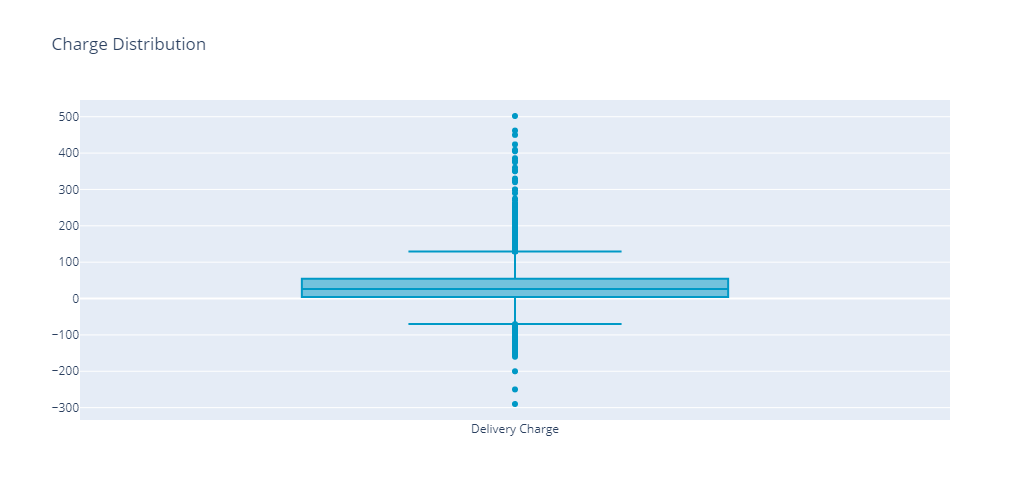

In [25]:
DELIVERY_CHARGE_df = delivery_clean_df.groupby(['DELIVERY_CHARGE']).count()

DELIVERY_CHARGE_df = pd.DataFrame(DELIVERY_CHARGE_df)

trace1 = go.Box(
    y = DELIVERY_CHARGE_df.index.values,
    name = "Delivery Charge",
    marker_color='#0099C6')
    #mode='lines+markers',
    #marker_size = DELIVERY_CHARGE_df['PROD_CD']/1000,
data = [trace1]
layout = go.Layout(title="Charge Distribution",
                   #xaxis= dict(title= 'MA Code',ticklen= 5,zeroline= False), 
                   #yaxis= dict(title= 'Amount',ticklen= 5,zeroline= False),
                   width=500,height=500)
fig = go.Figure(data = data, layout = layout)
fig.show()

In [29]:
delivery_clean_df = delivery_clean_df[delivery_clean_df['DELIVERY_CHARGE']>=0]

In [30]:
pd.set_option('display.float_format',lambda x : '%.2f' % x) #关闭科学计数法
delivery_clean_df.describe()

PROD_CD  PLU_RETAIL_PRICE  ORDER_STORE        DLC  DELIVERY_CHARGE  \
count 4008444.00        4008444.00   4008444.00 4008444.00       4008444.00   
mean   255038.08            383.84      3637.88   74345.77            20.16   
std    142151.86            315.61      1304.46     148.23            27.53   
min        92.00              9.97        13.00   74110.00             0.00   
25%    182027.00            219.00      2325.00   74230.00             0.00   
50%    229113.00            299.00      2923.00   74290.00            10.00   
75%    247338.00            419.00      4944.00   74470.00            30.00   
max    999279.00          14999.00      7017.00   74660.00           501.99   

       CUSTOMER_SEGMENT     VOLUME  BAND_FIFTY  LEAD_TIME  DELIVERY_WEEK  \
count        4008444.00 4008444.00  4008444.00 4008444.00     4008444.00   
mean               3.90       1.00      990.51       5.84           3.01   
std                2.37       0.00    12216.50       4.42           2.01   
min                0.00       1.00       50.00       0.00           0.00   
25%                2.00       1.00      250.00       3.00           1.00   
50%                4.00       1.00      300.00       5.00           3.00   
75%                6.00       1.00      450.00       7.00           5.00   
max                7.00       2.00   250000.00      30.00           6.00   

       DELIVERY_WEEKDAY_WEEKEND       WEEE  Installation  
count                4008444.00 4008444.00    4008444.00  
mean                       0.71       0.30          0.22  
std                        0.45       0.46          0.41  
min                        0.00       0.00          0.00  
25%                        0.00       0.00          0.00  
50%                        1.00       0.00          0.00  
75%                        1.00       1.00          0.00  
max                        1.00       1.00          1.00

In [31]:
Percentile_delivery_charge = np.percentile(delivery_clean_df['DELIVERY_CHARGE'],[0,25,50,75,100])
IQR_delivery_charge = Percentile_delivery_charge[3] - Percentile_delivery_charge[1]
UpLimit_delivery_charge = Percentile_delivery_charge[3]+IQR_delivery_charge*3
DownLimit_delivery_charge = Percentile_delivery_charge[1]-IQR_delivery_charge*3
print("uplimit:",UpLimit_delivery_charge,"Downlimit:",DownLimit_delivery_charge)

uplimit: 120.0 Downlimit: -90.0


In [32]:
outlier_delivery_charge_df = delivery_clean_df[delivery_clean_df['DELIVERY_CHARGE']>120]
outlier_delivery_charge_df.count()

MA                          28606
PROD_CD                     28606
BRAND                       28606
PLU_RETAIL_PRICE            28606
ORDER_STORE                 28606
ORDER_DATE                  28606
DELIVERY_DATE               28606
OUTCODE                     28606
DLC                         28606
SRV_TYPS                    28606
DELIVERY_CHARGE             28606
CUSTOMER_SEGMENT            28606
VOLUME                      28606
BAND_FIFTY                  28606
BOX_TYPE                    28606
LEAD_TIME                   28606
DELIVERY_WEEK               28606
DELIVERY_WEEKDAY_WEEKEND    28606
WEEE                        28606
AREA                        28606
D_OR_Q                      28606
Installation                28606
dtype: int64

In [33]:
delivery_clean_df = delivery_clean_df[delivery_clean_df['DELIVERY_CHARGE']<=120]

In [28]:
Percentile_lead_time = np.percentile(delivery_clean_df['LEAD_TIME'],[0,25,50,75,100])
IQR_lead_time = Percentile_lead_time[3] - Percentile_lead_time[1]
UpLimit_lead_time = Percentile_lead_time[3]+IQR_lead_time*3
DownLimit_lead_time = Percentile_lead_time[1]-IQR_lead_time*3
print("uplimit:",UpLimit_lead_time,"Downlimit:",DownLimit_lead_time)

uplimit: 19.0 Downlimit: -9.0


In [29]:
outlier_lead_time_df = delivery_clean_df[delivery_clean_df['LEAD_TIME']>20]
outlier_lead_time_df.count()

MA                          64080
PROD_CD                     64080
BRAND                       64080
PLU_RETAIL_PRICE            64080
ORDER_STORE                 64080
ORDER_DATE                  64080
DELIVERY_DATE               64080
OUTCODE                     64080
DLC                         64080
SRV_TYPS                    64080
DELIVERY_CHARGE             64080
CUSTOMER_SEGMENT            64080
VOLUME                      64080
BAND_FIFTY                  64080
BOX_TYPE                    64080
LEAD_TIME                   64080
DELIVERY_WEEK               64080
DELIVERY_WEEKDAY_WEEKEND    64080
WEEE                        64080
AREA                        64080
D_OR_Q                      64080
dtype: int64

### Tukey‘s test

In [3]:
delivery_clean_df = delivery_clean_df[delivery_clean_df['LEAD_TIME']<=20]

In [34]:
delivery_clean_df.count()

MA                          3979838
PROD_CD                     3979838
BRAND                       3979838
PLU_RETAIL_PRICE            3979838
ORDER_STORE                 3979838
ORDER_DATE                  3979838
DELIVERY_DATE               3979838
OUTCODE                     3979838
DLC                         3979838
SRV_TYPS                    3979838
DELIVERY_CHARGE             3979838
CUSTOMER_SEGMENT            3979838
VOLUME                      3979838
BAND_FIFTY                  3979838
BOX_TYPE                    3979838
LEAD_TIME                   3979838
DELIVERY_WEEK               3979838
DELIVERY_WEEKDAY_WEEKEND    3979838
WEEE                        3979838
AREA                        3979838
D_OR_Q                      3979838
Installation                3979838
dtype: int64

In [7]:
delivery_clean_df[delivery_clean_df['INSTALLATION']==1].count()

MA                          879701
PROD_CD                     879701
BRAND                       879701
PLU_RETAIL_PRICE            879701
ORDER_STORE                 879701
ORDER_DATE                  879701
DELIVERY_DATE               879701
OUTCODE                     879701
DLC                         879701
SRV_TYPS                    879701
DELIVERY_CHARGE             879701
CUSTOMER_SEGMENT            879701
VOLUME                      879701
BAND_FIFTY                  879701
BOX_TYPE                    879701
LEAD_TIME                   879701
DELIVERY_WEEK               879701
DELIVERY_WEEKDAY_WEEKEND    879701
WEEE                        879701
AREA                        879701
D_OR_Q                      879701
INSTALLATION                879701
dtype: int64

In [2]:
delivery_clean_df = pd.read_csv("clean_clean_version.csv", sep = ',')

In [39]:
delivery_clean_df = delivery_clean_df[delivery_clean_df['BOX_TYPE']=='BIG BOX']

In [13]:
delivery_clean_df.to_csv("clean_clean_MA_version.csv",sep=',', index=False)

In [6]:
delivery_clean_df.count()

MA                          3802578
PROD_CD                     3802578
BRAND                       3802578
PLU_RETAIL_PRICE            3802578
ORDER_STORE                 3802578
ORDER_DATE                  3802578
DELIVERY_DATE               3802578
OUTCODE                     3802578
DLC                         3802578
SRV_TYPS                    3802578
DELIVERY_CHARGE             3802578
CUSTOMER_SEGMENT            3802578
VOLUME                      3802578
BAND_FIFTY                  3802578
BOX_TYPE                    3802578
LEAD_TIME                   3802578
DELIVERY_WEEK               3802578
DELIVERY_WEEKDAY_WEEKEND    3802578
WEEE                        3802578
AREA                        3802578
D_OR_Q                      3802578
Installation                3802578
MA_CLEAN                    3802578
dtype: int64

In [10]:
delivery_clean_df['MA'].unique()

array(['RANGE COOKING', 'WASHER DRYERS', 'DISHWASHERS', 'INTEGRATED MDA',
       'LARGE SCREEN TELEVISION', 'TUMBLE DRYERS', 'RANGE COOKERS',
       'WASHING MACHINES', 'FRIDGE FREEZERS', 'BUILT-IN COOKING',
       'COOKING FREE STANDING', 'SLIM AMERICAN STYLE FRIDGE FRZ',
       '1 DOOR FRIDGES & FREEZERS', 'AMERICAN STYLE FRIDGE FREEZER'],
      dtype=object)

In [11]:
delivery_clean_df = delivery_clean_df[~delivery_clean_df['MA'].isin(['RANGE COOKING', 'PC GAMING HW', 'GAMING ACCESSORIES', 'HOME AUDIO','SMALL SCREEN TELEVISION','HOME THEATRE KITS','MONITORS','SEASONAL','TV STANDS AND BRACKETS','RANGE COOKERS'])]

In [12]:
len(delivery_clean_df['MA'].unique())

12

In [2]:
delivery_clean_df = pd.read_csv("clean_clean_MA_version.csv",sep=',')

In [6]:
def check_segmentn(x):
    if x==0:
        return 'Unknown'
    elif x==1:
        return 'Millennials'
    elif x==2:
        return 'Lower Income Families'
    elif x==3:
        return 'Middle Income Families'
    elif x==4:
        return 'High Earners'
    elif x==5:
        return 'Older Lower Income'
    elif x==6:
        return 'Older Middle Income'
    elif x==7:
        return 'Retired'
    
delivery_clean_df['CUSTOMER_SEGMENT'] = delivery_clean_df['CUSTOMER_SEGMENT'].apply(lambda x:check_segmentn(x))

In [9]:
delivery_clean_df.to_csv("clean_clean_MA_version.csv",sep=',', index=False)

In [6]:
delivery_clean_df['DELIVERY_DATE'].min()

'2019-01-03'

In [7]:
def week_day_or_end(x):
    if x == 0:
        return 1
    elif x == 6:
        return 1
    elif x == 5:
        return 1
    else:
        return 0
delivery_clean_df['IF_WEEKEND'] = delivery_clean_df['DELIVERY_WEEK'].apply(lambda x: week_day_or_end(x))
#Weekend = 1, Weekday = 0

In [20]:
delivery_clean_df.head()

MA   PROD_CD BRAND  PLU_RETAIL_PRICE  ORDER_STORE  ORDER_DATE  \
0  WASHER DRYERS  167925.0   SME            923.00         4944  2019-02-01   
1    DISHWASHERS  502663.0   MEI           1174.99         2425  2020-03-05   
2    DISHWASHERS  249066.0   AEG            929.00         4944  2019-11-05   
3    DISHWASHERS  507100.0   MEI           1044.99         4944  2020-03-07   
4    DISHWASHERS  507100.0   MEI           1044.99         4944  2020-03-10   

  DELIVERY_DATE OUTCODE      DLC SRV_TYPS  ...  D_OR_Q Installation  \
0    2019-02-07     EN6  74230.0       QI  ...       Q            1   
1    2020-03-09    BN15  74260.0        D  ...       D            0   
2    2019-11-06     SK6  74470.0        D  ...       D            0   
3    2020-03-12    WV10  74290.0       DN  ...       D            1   
4    2020-03-11    GU32  74215.0       DS  ...       D            0   

        MA_CLEAN  IF_WEEKEND ORDER_YEAR  ORDER_MONTH  ORDER_DAY  DELIVERY_DAY  \
0  WASHER DRYERS           0       2019           02         01            07   
1    DISHWASHERS           0       2020           03         05            09   
2    DISHWASHERS           0       2019           11         05            06   
3    DISHWASHERS           0       2020           03         07            12   
4    DISHWASHERS           0       2020           03         10            11   

   DELIVERY_MONTH DELIVERY_YEAR  
0              02          2019  
1              03          2020  
2              11          2019  
3              03          2020  
4              03          2020  

[5 rows x 30 columns]

In [14]:
def order_year(x):
    date1 = x['ORDER_DATE']
    year1,month1,day1=date1.split('-')
    return year1
delivery_clean_df['ORDER_YEAR']= delivery_clean_df.apply(lambda x: order_year(x),axis=1)

In [15]:
def order_month(x):
    date1 = x['ORDER_DATE']
    year1,month1,day1=date1.split('-')
    return month1
delivery_clean_df['ORDER_MONTH']= delivery_clean_df.apply(lambda x: order_month(x),axis=1)

In [16]:
def order_day(x):
    date1 = x['ORDER_DATE']
    year1,month1,day1=date1.split('-')
    return day1
delivery_clean_df['ORDER_DAY']= delivery_clean_df.apply(lambda x: order_day(x),axis=1)

In [17]:
def delivery_day(x):
    date1 = x['DELIVERY_DATE']
    year1,month1,day1=date1.split('-')
    return day1
delivery_clean_df['DELIVERY_DAY']= delivery_clean_df.apply(lambda x: delivery_day(x),axis=1)

In [18]:
def delivery_month(x):
    date1 = x['DELIVERY_DATE']
    year1,month1,day1=date1.split('-')
    return month1
delivery_clean_df['DELIVERY_MONTH']= delivery_clean_df.apply(lambda x: delivery_month(x),axis=1)

In [19]:
def delivery_year(x):
    date1 = x['DELIVERY_DATE']
    year1,month1,day1=date1.split('-')
    return year1
delivery_clean_df['DELIVERY_YEAR']= delivery_clean_df.apply(lambda x: delivery_year(x),axis=1)

In [24]:
delivery_clean_df.to_csv("clean_clean_MA_version.csv",sep=',', index=False)